In [1]:
import numpy as np
import math
import gym
from gym import spaces
import time
import random
from stable_baselines3 import  A2C, SAC,PPO
import torch
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common import results_plotter

In [2]:
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
import os

In [3]:
%matplotlib inline

In [4]:
gym.__version__

'0.21.0'

In [5]:
torch.__version__

'1.13.1'

In [6]:
!python3 -V

Python 3.7.7


## Utils

In [7]:
N_DISCRETE_ACTIONS=3

In [8]:
def alter_coord(action, position, g_coord, dx=0.1, change_nodes=[2,3,5,7]):
        
    if action==0:
        g_coord[int(2*change_nodes[position])]+=dx
    elif action==1:
        g_coord[int(2*change_nodes[position])]-=dx
    elif action==2:
        g_coord[int(2*change_nodes[position])]+=0
             
    return g_coord

In [9]:
def observe(position, coord,l1,l2, displ,action):    
    return np.array([position, coord[4]/l2, coord[6]/l1, coord[10]/l1, coord[14]/l2, displ[9], action])

In [10]:
def draw(coord,color,elcon):
    coord=coord.reshape(np.max(elcon)+1,2)
    plt.figure(figsize=(13,5))
    for item in elcon:
        plt.plot([coord[item[0]][0],coord[item[1]][0]],[coord[item[0]][1],coord[item[1]][1]],color=color)

    plt.show() 

In [11]:
def reward_(obs_,obs):   
    if abs(obs_[5])>abs(obs[5]):  
        return 1
    else:
        return 0

## Finite Element Model of the Plane Truss structure

In [12]:
def PlaneTrussElementLength(x1,y1,x2,y2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))

In [13]:
def PlaneTrussElementStiffness(E,A,L,theta):
    x = theta*math.pi/180
    C = math.cos(x)
    S = math.sin(x)
    return E*A/L*np.array([[C*C, C*S, -C*C, -C*S],[C*S, S*S, -C*S, -S*S],
                           [-C*C, -C*S, C*C, C*S],[-C*S, -S*S, C*S, S*S]]) 

In [14]:
def PlaneTrussAssemble(K,k,i,j):
    # K - np.array
    # k - np.array
    K[2*i,2*i] = K[2*i,2*i] + k[0,0]
    K[2*i,2*i+1] = K[2*i,2*i+1] + k[0,1] 
    K[2*i,2*j] = K[2*i,2*j] + k[0,2] 
    K[2*i,2*j+1] = K[2*i,2*j+1] + k[0,3]
    K[2*i+1,2*i] = K[2*i+1,2*i] + k[1,0]
    K[2*i+1,2*i+1] = K[2*i+1,2*i+1] + k[1,1] 
    K[2*i+1,2*j] = K[2*i+1,2*j] + k[1,2] 
    K[2*i+1,2*j+1] = K[2*i+1,2*j+1] + k[1,3] 
    K[2*j,2*i] = K[2*j,2*i] + k[2,0] 
    K[2*j,2*i+1] = K[2*j,2*i+1] + k[2,1]
    K[2*j,2*j] = K[2*j,2*j] + k[2,2]
    K[2*j,2*j+1] = K[2*j,2*j+1] + k[2,3] 
    K[2*j+1,2*i] = K[2*j+1,2*i] + k[3,0] 
    K[2*j+1,2*i+1] = K[2*j+1,2*i+1] + k[3,1]
    K[2*j+1,2*j] = K[2*j+1,2*j] + k[3,2] 
    K[2*j+1,2*j+1] = K[2*j+1,2*j+1] + k[3,3]
    
    return K   

In [15]:
def PlaneTrussElementForce(E,A,L,theta,u):
    x = theta* math.pi/180
    C = math.cos(x)
    S = math.sin(x)
    return E*A/L*np.dot(np.array([-C, -S, C, S]),u)

In [16]:
def PlaneTrussElementStress(E,L,theta,u):
    x = theta * math.pi/180
    C = math.cos(x)
    S = math.sin(x)
    return E/L*np.dot(np.array([-C, -S, C, S]),u)

In [17]:
def FEA_u(coord, elcon, bc_node, bc_val, global_force,  A=1e-4, E=210e6):
    K=np.zeros(shape=(2*np.max(elcon)+2,2*np.max(elcon)+2))
    for el in elcon:
        L=PlaneTrussElementLength(coord[el[0]][0],coord[el[0]][1],coord[el[1]][0],coord[el[1]][1])
        theta=math.atan((coord[el[1]][1]-coord[el[0]][1])/(coord[el[1]][0]-coord[el[0]][0]+1e-13))*180/math.pi
        k=PlaneTrussElementStiffness(E,A,L,theta)
        K=PlaneTrussAssemble(K,k,el[0],el[1])     
    
    F = global_force
    
    
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    bc=np.array([bc_node, 
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)

    s=np.linalg.lstsq(K[fdof,:][:,fdof],
                      (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, rcond=None)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    
#     Q=np.dot(K,d).T-F 
    
    return d

In [18]:
# 5 The Plane Truss Element - verification 
d=FEA_u(np.array([0,0,
                  4,0,
                  2,3]).reshape(3,2), 
      elcon=np.array([[0, 1],
                      [0, 2],
                      [1, 2]]),
      bc_node = [0, 1, 3],
      bc_val = [0., 0., 0.],
      global_force = np.array([0,0,
                               0,0,
                               5,-10]),
      A=1e-4, 
      E=210e6)

In [19]:
d

array([ 0.        ,  0.        ,  0.00111111,  0.        ,  0.00195056,
       -0.00161037])

## Reinforcement learning model

In [20]:
class BridgeEnv(gym.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.pst=random.randint(0,3)
        self.g_coord = alter_coord(2, self.pst, np.array([0.0,0.0,2.0,3.0,2.0,0.0,5.0,3.0,7.0,0.0,9.0,3.0,12.0,3.0,12.0,0.0,14.0,0.0]),
                                          dx=0.1, change_nodes=[2,3,5,7])
        self.displ = FEA_u(self.g_coord.reshape(9,2), elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                                                    [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                                                    [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]),
                                                    bc_node=[0,1,
                                                             2,3,
                                                             12,13,
                                                             16,17],
                                                    bc_val=[0,0,
                                                            0,0,
                                                            0,0,
                                                            0,0],
                                                    global_force = np.array([0,0,
                                                                    0,0,
                                                                    0,0,
                                                                    0,0,
                                                                    0,-10,
                                                                    0,0,
                                                                    0,0,
                                                                    0,0,
                                                                    0,0]),
                                                    A=1e-4, E=210e6)
        
        self.obs=observe(self.pst, self.g_coord, 10, 14, self.displ,0)
        
        self.observation_space = spaces.Box(low=np.array([-np.inf,
                                                          -np.inf,
                                                          -np.inf,
                                                          -np.inf,
                                                          -np.inf,
                                                          -np.inf,
                                                          -np.inf]),
                                            high=np.array([np.inf,
                                                           np.inf,
                                                           np.inf,
                                                           np.inf,
                                                           np.inf,
                                                           np.inf,
                                                           np.inf]),shape=(7,),
                                           dtype=np.float64)
        self.needs_reset = True

    def step(self, action):
        obs_=self.obs 
        
        g_coord = alter_coord(action, self.pst, self.g_coord, dx=0.1, change_nodes=[2,3,5,7])
        
        pst=random.randint(0,3)
        self.pst=pst
        
        done=False
        
        if g_coord[4]<g_coord[0]+0.2 or g_coord[4]>g_coord[8]-0.2:
            done=True

        if g_coord[6]<g_coord[2]+0.2 or g_coord[6]>g_coord[12]-0.2:
            done=True

        if g_coord[10]<g_coord[2]+0.2 or g_coord[10]>g_coord[12]-0.2:
            done=True

        if g_coord[14]<g_coord[8]+0.2 or g_coord[14]>g_coord[16]-0.2:
            done=True   

        displ = FEA_u(g_coord.reshape(9,2), elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                                            [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                                            [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]),
                                                    bc_node=[0,1,
                                                             2,3,
                                                             12,13,
                                                             16,17],
                                                    bc_val=[0,0,
                                                            0,0,
                                                            0,0,
                                                            0,0],
                                                    global_force = np.array([0,0,
                                                                    0,0,
                                                                    0,0,
                                                                    0,0,
                                                                    0,-10,
                                                                    0,0,
                                                                    0,0,
                                                                    0,0,
                                                                    0,0]),
                                                    A=1e-4, E=210e6)
        self.obs=observe(pst,g_coord,10,14,displ,action)               
        reward=reward_(obs_,self.obs)
        self.g_coord=g_coord
        
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
      
        return self.obs, reward, done, dict()

    def reset(self):
        self.pst = random.randint(0,3)
        self.g_coord = alter_coord(2, self.pst, np.array([0.0,0.0,
                                                          2.0,3.0,
                                                          2.0,0.0,
                                                          5.0,3.0,
                                                          7.0,0.0,
                                                          9.0,3.0,
                                                          12.0,3.0,
                                                          12.0,0.0,
                                                          14.0,0.0]),
                                          dx=0.1, change_nodes=[2,3,5,7])
        self.displ = FEA_u(self.g_coord.reshape(9,2), elcon=np.array([[0, 1],
                                                                      [0, 2],
                                                                      [1, 2],
                                                                      [1, 3],
                                                                      [2, 3],
                                                                      [2, 4],
                                                                      [3, 4],
                                                                      [3, 5],
                                                                      [4, 5],
                                                                      [4, 7],
                                                                      [5, 7],
                                                                      [5, 6],
                                                                      [6, 7],
                                                                      [6, 8],
                                                                      [7, 8]]),
                                                    bc_node=[0,1,
                                                             2,3,
                                                             12,13,
                                                             16,17],
                                                    bc_val=[0,0,
                                                            0,0,
                                                            0,0,
                                                            0,0],
                                                    global_force = np.array([0,0,
                                                                    0,0,
                                                                    0,0,
                                                                    0,0,
                                                                    0,-10,
                                                                    0,0,
                                                                    0,0,
                                                                    0,0,
                                                                    0,0]),
                                                    A=1e-4, E=210e6)
        
        self.obs=observe(self.pst, self.g_coord, 10, 14, self.displ,0)
        self.needs_reset = False
        return self.obs  

    def render(self, mode="human"):
        
        
        draw(self.g_coord, color="green", elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                                                    [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                                                    [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]))    

    def close(self):
        pass

In [21]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [22]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

env = BridgeEnv()
env = Monitor(env, log_dir)
check_env(env)

In [23]:
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [24]:
ts=5e5

In [25]:
start=time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()   

Num timesteps: 4000
Best mean reward: -inf - Last mean reward per episode: 1266.00
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 5000
Best mean reward: 1266.00 - Last mean reward per episode: 1266.00
Num timesteps: 6000
Best mean reward: 1266.00 - Last mean reward per episode: 682.67
Num timesteps: 7000
Best mean reward: 1266.00 - Last mean reward per episode: 590.50
Num timesteps: 8000
Best mean reward: 1266.00 - Last mean reward per episode: 471.83
Num timesteps: 9000
Best mean reward: 1266.00 - Last mean reward per episode: 438.00
Num timesteps: 10000
Best mean reward: 1266.00 - Last mean reward per episode: 400.00
Num timesteps: 11000
Best mean reward: 1266.00 - Last mean reward per episode: 370.18
Num timesteps: 12000
Best mean reward: 1266.00 - Last mean reward per episode: 362.67
Num timesteps: 13000
Best mean reward: 1266.00 - Last mean reward per episode: 349.86
Num timesteps: 14000
Best mean reward: 1266.00 - Last mean reward per episode: 352.80
Num timestep

Num timesteps: 99000
Best mean reward: 1266.00 - Last mean reward per episode: 446.79
Num timesteps: 100000
Best mean reward: 1266.00 - Last mean reward per episode: 448.21
Num timesteps: 101000
Best mean reward: 1266.00 - Last mean reward per episode: 448.21
Num timesteps: 102000
Best mean reward: 1266.00 - Last mean reward per episode: 454.59
Num timesteps: 103000
Best mean reward: 1266.00 - Last mean reward per episode: 457.11
Num timesteps: 104000
Best mean reward: 1266.00 - Last mean reward per episode: 460.22
Num timesteps: 105000
Best mean reward: 1266.00 - Last mean reward per episode: 462.46
Num timesteps: 106000
Best mean reward: 1266.00 - Last mean reward per episode: 463.40
Num timesteps: 107000
Best mean reward: 1266.00 - Last mean reward per episode: 465.94
Num timesteps: 108000
Best mean reward: 1266.00 - Last mean reward per episode: 468.54
Num timesteps: 109000
Best mean reward: 1266.00 - Last mean reward per episode: 469.43
Num timesteps: 110000
Best mean reward: 1266

Num timesteps: 194000
Best mean reward: 1266.00 - Last mean reward per episode: 622.62
Num timesteps: 195000
Best mean reward: 1266.00 - Last mean reward per episode: 626.10
Num timesteps: 196000
Best mean reward: 1266.00 - Last mean reward per episode: 626.10
Num timesteps: 197000
Best mean reward: 1266.00 - Last mean reward per episode: 634.63
Num timesteps: 198000
Best mean reward: 1266.00 - Last mean reward per episode: 636.73
Num timesteps: 199000
Best mean reward: 1266.00 - Last mean reward per episode: 636.73
Num timesteps: 200000
Best mean reward: 1266.00 - Last mean reward per episode: 636.73
Num timesteps: 201000
Best mean reward: 1266.00 - Last mean reward per episode: 636.73
Num timesteps: 202000
Best mean reward: 1266.00 - Last mean reward per episode: 653.22
Num timesteps: 203000
Best mean reward: 1266.00 - Last mean reward per episode: 646.30
Num timesteps: 204000
Best mean reward: 1266.00 - Last mean reward per episode: 644.98
Num timesteps: 205000
Best mean reward: 126

Num timesteps: 289000
Best mean reward: 1266.00 - Last mean reward per episode: 654.48
Num timesteps: 290000
Best mean reward: 1266.00 - Last mean reward per episode: 652.91
Num timesteps: 291000
Best mean reward: 1266.00 - Last mean reward per episode: 652.91
Num timesteps: 292000
Best mean reward: 1266.00 - Last mean reward per episode: 652.91
Num timesteps: 293000
Best mean reward: 1266.00 - Last mean reward per episode: 652.91
Num timesteps: 294000
Best mean reward: 1266.00 - Last mean reward per episode: 662.40
Num timesteps: 295000
Best mean reward: 1266.00 - Last mean reward per episode: 657.07
Num timesteps: 296000
Best mean reward: 1266.00 - Last mean reward per episode: 657.07
Num timesteps: 297000
Best mean reward: 1266.00 - Last mean reward per episode: 657.07
Num timesteps: 298000
Best mean reward: 1266.00 - Last mean reward per episode: 657.07
Num timesteps: 299000
Best mean reward: 1266.00 - Last mean reward per episode: 674.01
Num timesteps: 300000
Best mean reward: 126

Num timesteps: 384000
Best mean reward: 1266.00 - Last mean reward per episode: 869.16
Num timesteps: 385000
Best mean reward: 1266.00 - Last mean reward per episode: 882.98
Num timesteps: 386000
Best mean reward: 1266.00 - Last mean reward per episode: 882.98
Num timesteps: 387000
Best mean reward: 1266.00 - Last mean reward per episode: 885.27
Num timesteps: 388000
Best mean reward: 1266.00 - Last mean reward per episode: 886.14
Num timesteps: 389000
Best mean reward: 1266.00 - Last mean reward per episode: 885.06
Num timesteps: 390000
Best mean reward: 1266.00 - Last mean reward per episode: 885.90
Num timesteps: 391000
Best mean reward: 1266.00 - Last mean reward per episode: 886.28
Num timesteps: 392000
Best mean reward: 1266.00 - Last mean reward per episode: 888.34
Num timesteps: 393000
Best mean reward: 1266.00 - Last mean reward per episode: 888.93
Num timesteps: 394000
Best mean reward: 1266.00 - Last mean reward per episode: 888.93
Num timesteps: 395000
Best mean reward: 126

Num timesteps: 478000
Best mean reward: 1266.00 - Last mean reward per episode: 1009.86
Num timesteps: 479000
Best mean reward: 1266.00 - Last mean reward per episode: 1009.86
Num timesteps: 480000
Best mean reward: 1266.00 - Last mean reward per episode: 1009.86
Num timesteps: 481000
Best mean reward: 1266.00 - Last mean reward per episode: 1023.90
Num timesteps: 482000
Best mean reward: 1266.00 - Last mean reward per episode: 1023.90
Num timesteps: 483000
Best mean reward: 1266.00 - Last mean reward per episode: 1033.32
Num timesteps: 484000
Best mean reward: 1266.00 - Last mean reward per episode: 1033.32
Num timesteps: 485000
Best mean reward: 1266.00 - Last mean reward per episode: 1033.32
Num timesteps: 486000
Best mean reward: 1266.00 - Last mean reward per episode: 1033.32
Num timesteps: 487000
Best mean reward: 1266.00 - Last mean reward per episode: 1025.84
Num timesteps: 488000
Best mean reward: 1266.00 - Last mean reward per episode: 1025.84
Num timesteps: 489000
Best mean 

In [26]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 19.652825848261514 min


### Design by AI

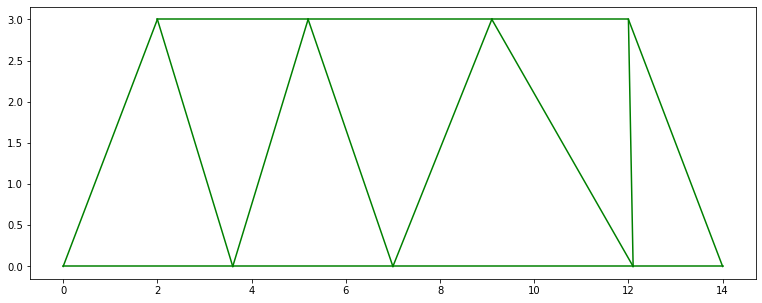

In [27]:
obs = env.reset()
i=0
while i<50:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    i+=1
    
env.render()    

In [33]:
obs[-2]

-0.004604604588490783

In [29]:
d=FEA_u(np.array([0.0,0.0, 
                2.0,3.0, 
                2.0,0.0, 
                5.0,3.0, 
                7.0,0.0,
                9.0,3.0,
                12.0,3.0,
                12.0,0.0,
                14.0,0.0]).reshape(9,2), 
      elcon=np.array([[0, 1],
                      [0, 2],
                      [1, 2],
                      [1, 3],
                      [2, 3],
                      [2, 4],
                      [3, 4],
                      [3, 5],
                      [4, 5],
                      [4, 7],
                      [5, 7],
                      [5, 6],
                      [6, 7],
                      [6, 8],
                      [7, 8]]),
      bc_node=[0,1,
               2,3,
               12,13,
               16,17],
      bc_val=[0,0,
              0,0,
              0,0,
              0,0],
      global_force = np.array([0,0,
                              0,0,
                              0,0,
                              0,0,
                              0,-10,
                              0,0,
                              0,0,
                              0,0,
                              0,0]),
      A=1e-4, E=210e6)

In [30]:
# Benchmark from initial design:
d[9]

-0.005108382058368501

### Initial Design 

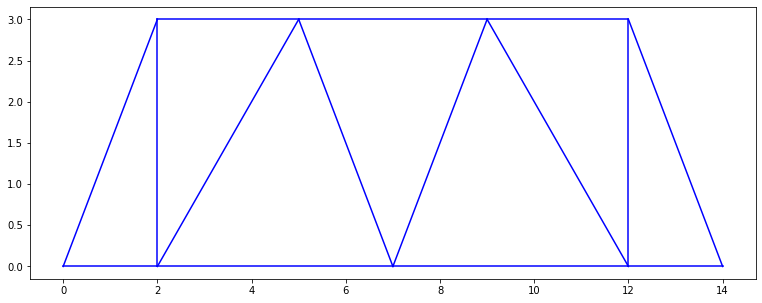

In [31]:
draw(np.array([0.0,0.0,2.0,3.0,2.0,0.0,5.0,3.0,7.0,0.0,9.0,3.0,12.0,3.0,12.0,0.0,14.0,0.0]),
     color="blue",
     elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                    [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                    [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]))

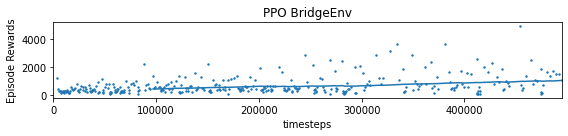

In [32]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "PPO BridgeEnv")